<a id="import"></a>
# <center>Loop through different quality levels in "Data" folder and train a Model for 20 epochs.</center>

The script takes reference from the Model Training file.

Found 1095 validated image filenames belonging to 3 classes.
Found 137 validated image filenames belonging to 3 classes.
Found 137 validated image filenames belonging to 3 classes.
test batch size:  1   test steps:  137
ask_epoch >= epochs, will train for  20  epochs
Training will proceed until epoch 20  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 8.1738 - accuracy: 0.7160
 validation loss of  8.6396 is    0.00 % below lowest loss, saving weights from epoch 1   as best weights
35/35 [==============================] - 227s 6s/step - loss: 8.1738 - accuracy: 0.7160 - val_loss: 8.6396 - val_accuracy: 0.6058
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 6.9321 - accuracy: 0.8192
 validation loss of  7.1215 is   17.57 % below lowest loss, saving weights from epoch 2   as best weights
35/35 [==============================] -

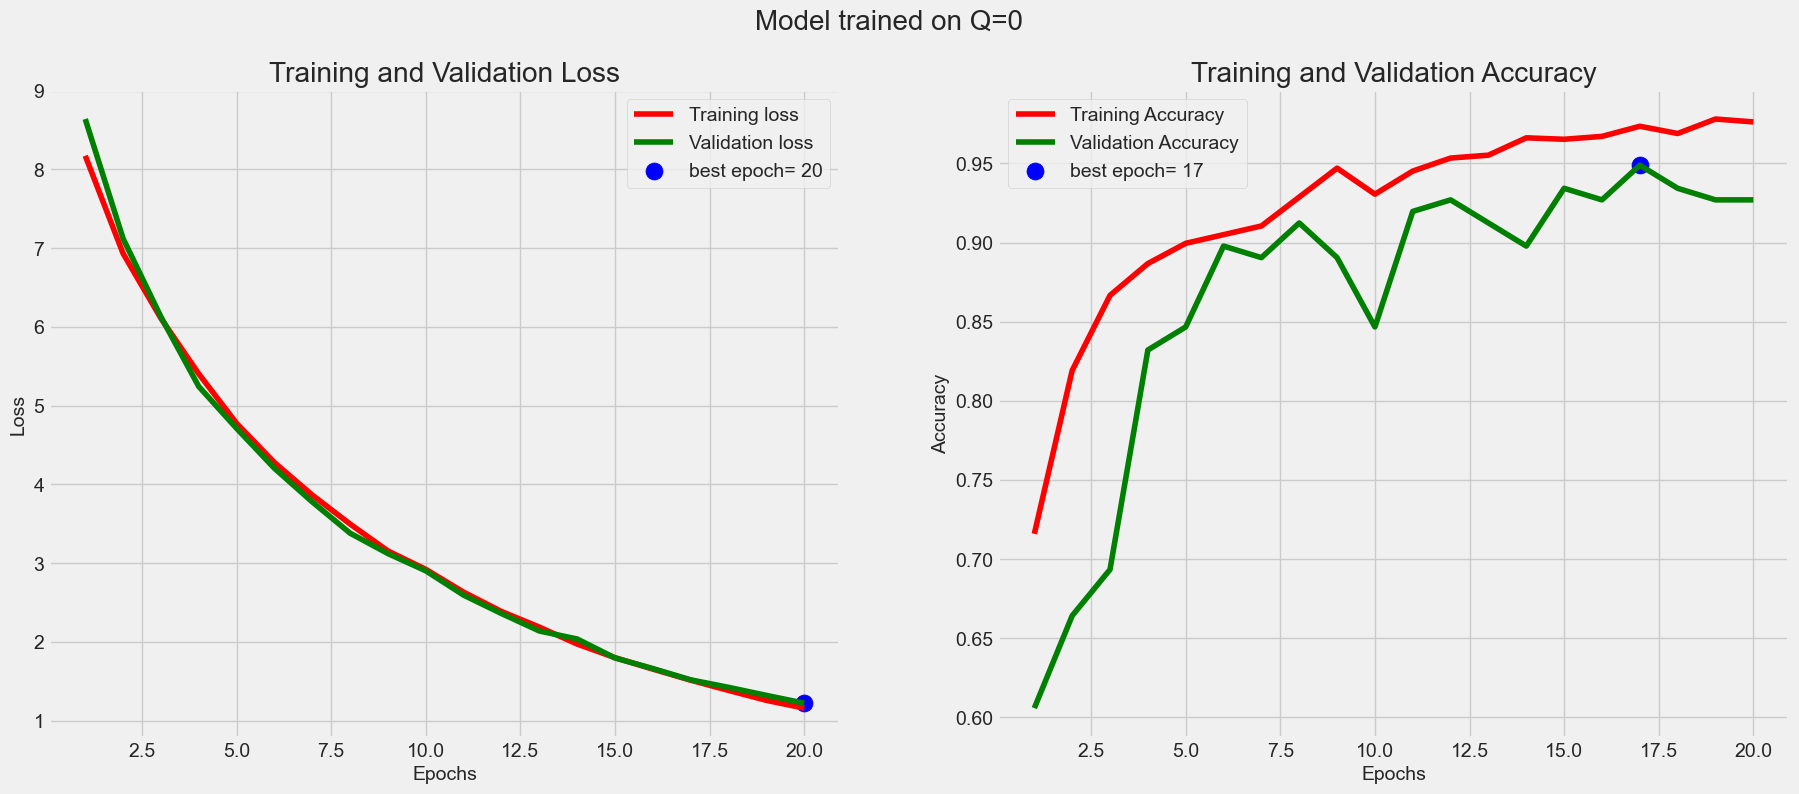

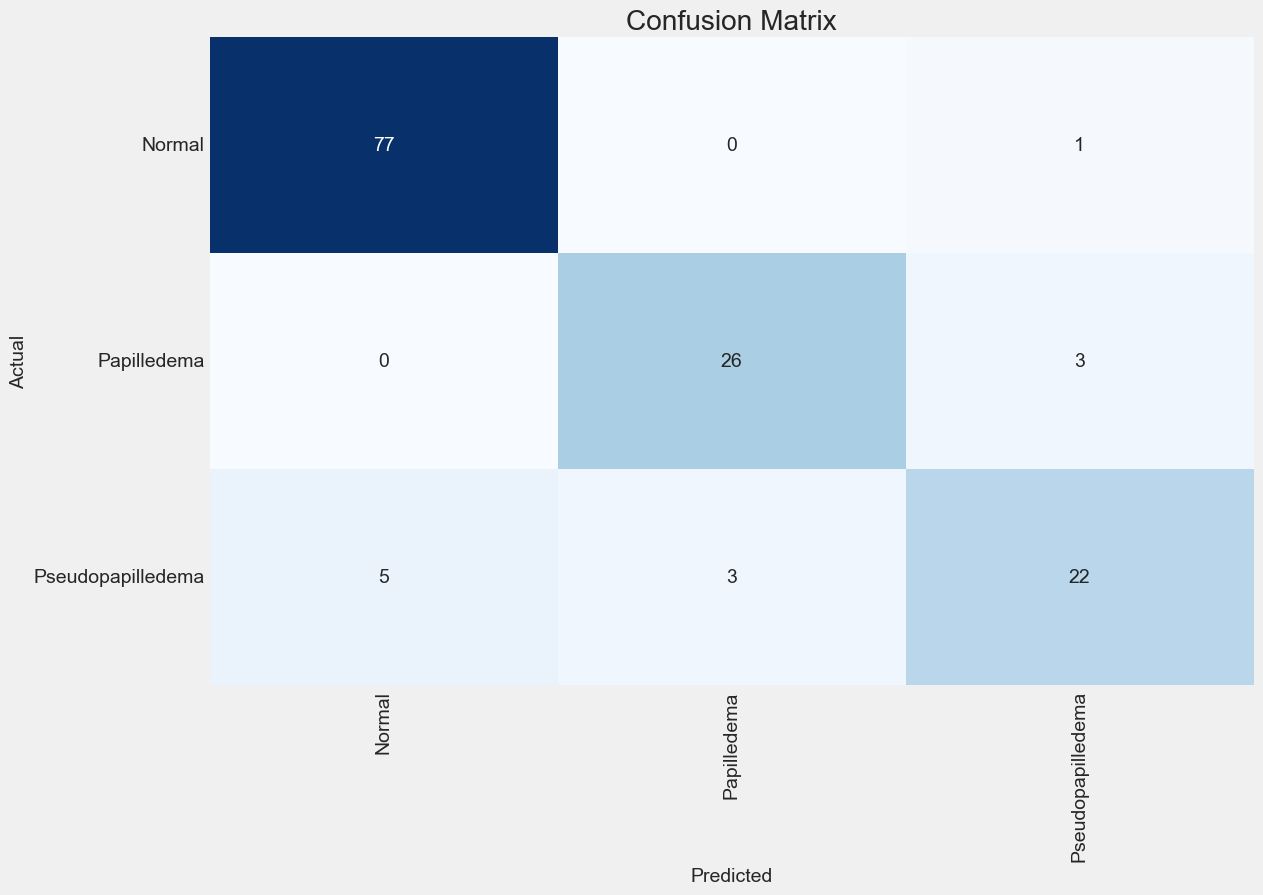

Classification Report:
----------------------
                    precision    recall  f1-score   support

           Normal     0.9390    0.9872    0.9625        78
      Papilledema     0.8966    0.8966    0.8966        29
Pseudopapilledema     0.8462    0.7333    0.7857        30

         accuracy                         0.9124       137
        macro avg     0.8939    0.8724    0.8816       137
     weighted avg     0.9097    0.9124    0.9098       137

model was saved as  Models\Q=0_91.24
Found 1095 validated image filenames belonging to 3 classes.
Found 137 validated image filenames belonging to 3 classes.
Found 137 validated image filenames belonging to 3 classes.
test batch size:  1   test steps:  137
ask_epoch >= epochs, will train for  20  epochs
Training will proceed until epoch 20  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 7.

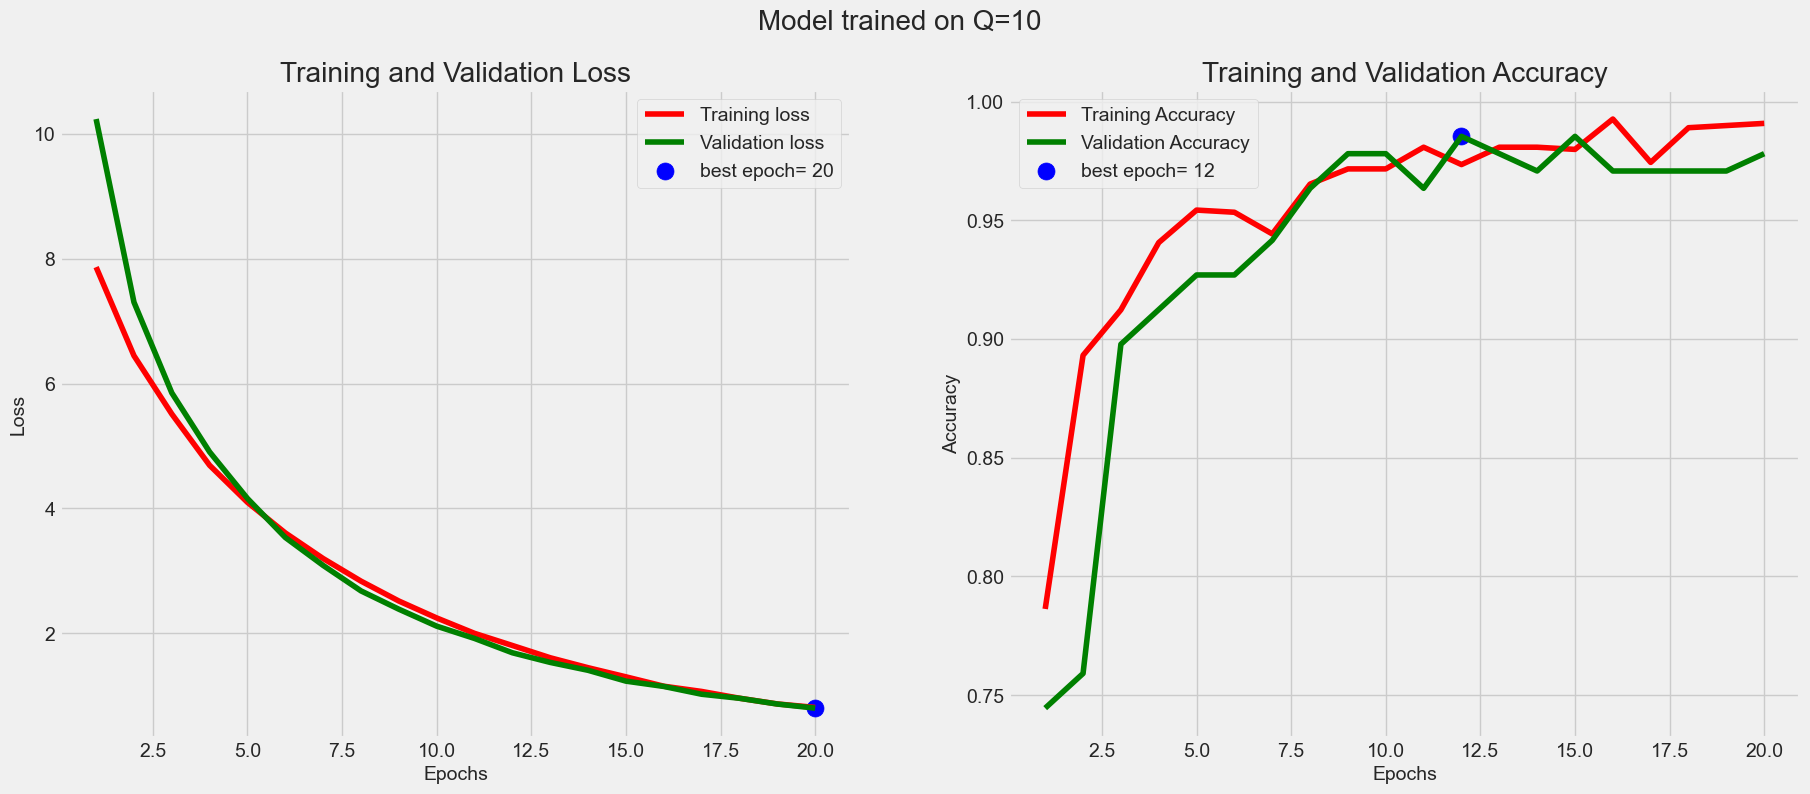

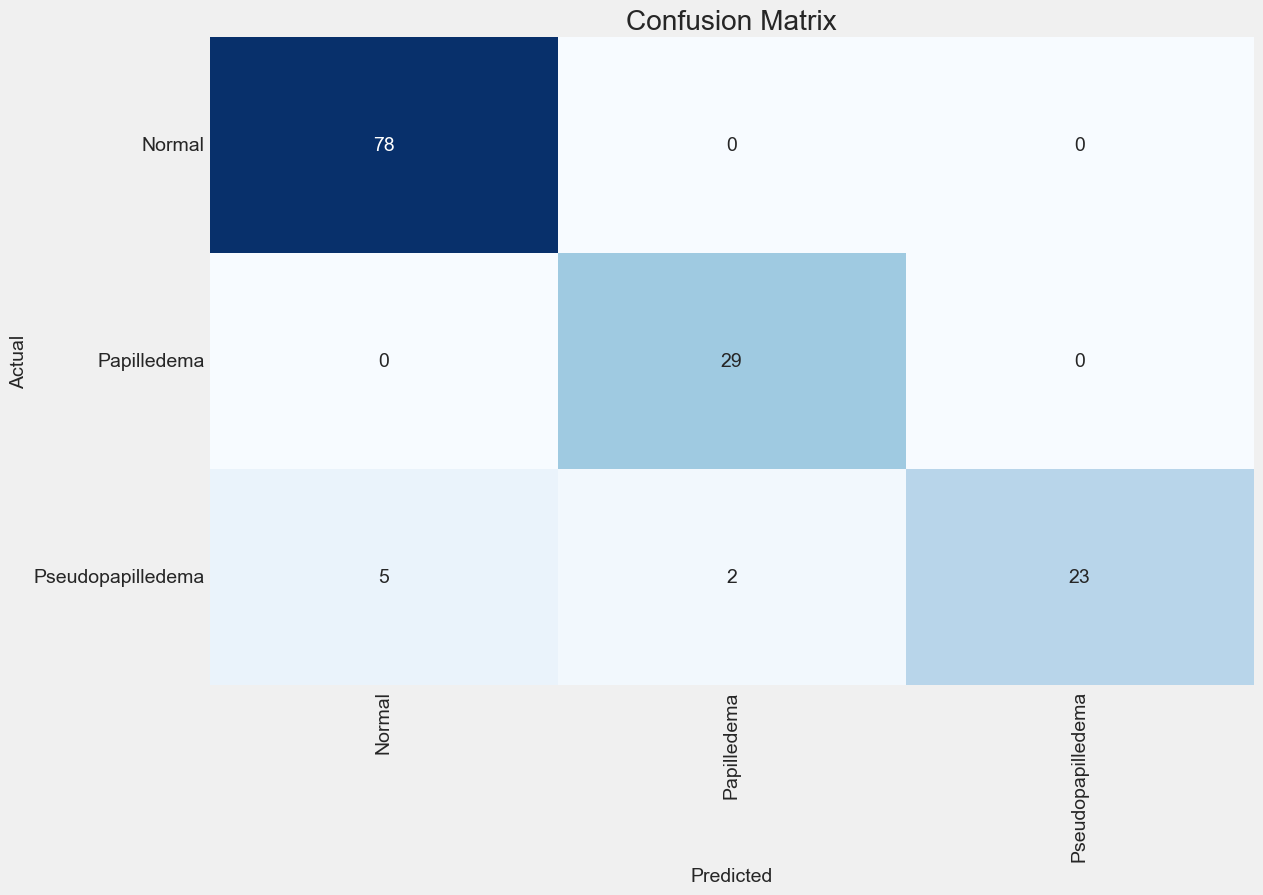

Classification Report:
----------------------
                    precision    recall  f1-score   support

           Normal     0.9398    1.0000    0.9689        78
      Papilledema     0.9355    1.0000    0.9667        29
Pseudopapilledema     1.0000    0.7667    0.8679        30

         accuracy                         0.9489       137
        macro avg     0.9584    0.9222    0.9345       137
     weighted avg     0.9520    0.9489    0.9463       137

model was saved as  Models\Q=10_94.89


In [2]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout,BatchNormalization
from keras.optimizers import Adamax
from keras import regularizers
from keras.models import Model
#######################################################################################################################

ddir = 'Data\\'
for subject in sorted(os.listdir(ddir)):

    cdir= ddir + subject

    filepaths = []
    labels=[]
    relpath = [] 
    classlist=sorted(os.listdir(cdir))  
    for klass in classlist:
        classpath=os.path.join(cdir, klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    df=pd.concat([Fseries, Lseries], axis=1)
        
    train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=23, stratify=df['labels'])
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=23, stratify=dummy_df['labels'])
    #######################################################################################################################
    img_size=(240,240)

    #Image Augmentation
    trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                            height_shift_range=.2, zoom_range=.2 )
    t_and_v_gen=ImageDataGenerator()

    #creating train gen
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                    class_mode='categorical', color_mode='rgb', shuffle=True)

    #creating valid gen
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                            class_mode='categorical', color_mode='rgb', shuffle=False)

    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)

    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

    #info used later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
    ##########################################################################################################################################
    img_shape=(img_size[0], img_size[1], 3)
    model_name='EfficientNetB3'
    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

    base_model.trainable=True

    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
            bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    lr=.001 # start with this learning rate
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    ########################################################################################################################################
    class LR_ASK(keras.callbacks.Callback):
        def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
            super(LR_ASK, self).__init__()
            self.model=model               
            self.ask_epoch=ask_epoch
            self.epochs=epochs
            self.ask=False # if True query the user on a specified epoch
            self.lowest_vloss=np.inf
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=1
            
            
        def on_train_begin(self, logs=None): # this runs on the beginning of training
            if self.ask_epoch == 0: 
                print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
                self.ask_epoch=1
            if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
                print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
                self.ask=False # do not query the user
            if self.epochs == 1:
                self.ask=False # running only for 1 epoch so do not query user
            else:
                print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
                print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
            self.start_time= time.time() # set the time at which training started
            
        def on_train_end(self, logs=None):   # runs at the end of training  
            print('loading model with weights from epoch ', self.best_epoch)
            self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
            tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
            hours = tr_duration // 3600
            minutes = (tr_duration - (hours * 3600)) // 60
            seconds = tr_duration - ((hours * 3600) + (minutes * 60))
            msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
            print (msg, flush=True) # print out training duration time
            
        def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
            v_loss=logs.get('val_loss')  # get the validation loss for this epoch
            if v_loss< self.lowest_vloss:
                if epoch !=0:
                    pimprov= (self.lowest_vloss - v_loss) * 100/self.lowest_vloss
                else:
                    pimprov=0
                self.lowest_vloss=v_loss
                self.best_weights=self.model.get_weights() # set best weights to model's initial weights
                self.best_epoch=epoch + 1
                
                print (f'\n validation loss of {v_loss:7.4f} is {pimprov:7.2f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
            else:
                print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
            
            if self.ask: # are the conditions right to query the user?
                if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                    print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                    ans=input()
                    
                    if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                        print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                        self.model.stop_training = True # halt training
                    else: # user wants to continue training
                        self.ask_epoch += int(ans)
                        if self.ask_epoch > self.epochs:
                            print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                        else:
                            print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                            ans=input()
                            if ans =='':
                                print (f'keeping current LR of {lr:7.5f}')
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                print(' changing LR to ', ans)
    #############################################################################################################################################
    epochs=20
    ask_epoch=20
    ask=LR_ASK(model, epochs,  ask_epoch)
    callbacks=[ask]
    #############################################################################################################################################
    history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
                validation_steps=None,  shuffle=False,  initial_epoch=0)
    #############################################################################################################################################
    def tr_plot(tr_data, start_epoch):
        #Plot the training and validation data
        tacc=tr_data.history['accuracy']
        tloss=tr_data.history['loss']
        vacc=tr_data.history['val_accuracy']
        vloss=tr_data.history['val_loss']
        Epoch_count=len(tacc)+ start_epoch
        Epochs=[]
        for i in range (start_epoch ,Epoch_count):
            Epochs.append(i+1)   
        index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
        val_lowest=vloss[index_loss]
        index_acc=np.argmax(vacc)
        acc_highest=vacc[index_acc]
        plt.style.use('fivethirtyeight')
        sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
        vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
        fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
        axes[0].plot(Epochs,tloss, 'r', label='Training loss')
        axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
        axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
        axes[0].set_title('Training and Validation Loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
        axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
        axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
        axes[1].set_title('Training and Validation Accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        plt.tight_layout
        plt_name = "Model trained on " +subject
        fig.suptitle(plt_name, fontsize=20)
        plt.savefig(os.path.join("Information\\Model Training Information", plt_name)+'.png')
        
    tr_plot(history,0)
    #######################################################################################################################
    def predictor(test_gen, test_steps):
        y_pred= []
        y_true=test_gen.labels
        classes=list(test_gen.class_indices.keys())
        class_count=len(classes)
        errors=0
        preds=model.predict(test_gen, verbose=1)
        tests=len(preds)    
        for i, p in enumerate(preds):        
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values        
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
                file=test_gen.filenames[i]            
            y_pred.append(pred_index)
                
        acc=( 1-errors/tests) * 100
        print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
        ypred=np.array(y_pred)
        ytrue=np.array(y_true)
        if class_count <=30:
            cm = confusion_matrix(ytrue, ypred )
            # plot the confusion matrix
            plt.figure(figsize=(12, 8))
            sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
            plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
            plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix")
            plt.show()
        clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
        return errors, tests
    errors, tests=predictor(test_gen, test_steps)
    ##########################################################################################################################
    acc=str(( 1-errors/tests) * 100)
    index=acc.rfind('.')
    acc=acc[:index + 3]
    save_id= subject + '_' + str(acc)
    model_save_loc=os.path.join("Models\\", save_id)
    model.save(model_save_loc, save_format='h5')
    print ('model was saved as ' , model_save_loc )